In [1]:
from run import Runner
from mytorch.utils.goodies import FancyDict
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
from typing import Union, Optional, Dict

In [2]:
args = {'name' : 'testrun',
'dataset' : 'RLF/lf',
'model' : 'compgcn',
'score_func' : 'conve',
'opn' : 'corr',                 
'use_wandb' : False, 
'batch_size' : 128,       
'gamma' : 40.0,			
'gpu' : '-1',			
'max_epochs' : 1,  	
'l2' : 0.0,			
'lr' : 0.001,			
'lbl_smooth' : 0.1,	
'num_workers' : 10,                     
'seed' : 41504,     	
'restore' : False,            
'bias' : False   ,         
'num_bases' : -1, 	
'init_dim' : 100,	
'gcn_dim' : 200 ,	
'embed_dim' : None, 	
'gcn_layer' : 1 	,
'dropout' : 0.1	,
'hid_drop' : 0.3	,
'hid_drop2' : 0.3	,
'feat_drop' : 0.3	,
'k_w' : 10 	,
'k_h' : 20 	,
'num_filt' : 200, 	
'ker_sz' : 7 	,
'log_dir' : './log/',               
'config_dir' : './config/',
'trim': False,
'trim_ratio': 0.00005,
'use_fasttext': False
}
args = FancyDict(args)

model = Runner(args)

2023-07-21 16:39:29,312 - [INFO] - {}
{}


/home/priyansh/Dev/perm/conda/envs/main/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
# # Now load the saved model
model.load_model('./checkpoints/compgcn-conve-rlffam')

In [4]:
df_tr = pd.DataFrame(model.data['train'], columns=['sub', 'rel', 'obj'])
df_tr['split'] = 'train'
df_tr

df_vl = pd.DataFrame(model.data['valid'], columns=['sub', 'rel', 'obj'])
df_vl['split'] = 'valid'
df_vl

df_ts = pd.DataFrame(model.data['test'], columns=['sub', 'rel', 'obj'])
df_ts['split'] = 'test'

dfs = {'train': df_tr, 'valid': df_vl, 'test': df_ts}

df_ts

,sub,rel,obj,split
0,14710,0,15875,test
1,13469,0,18787,test
2,3007,0,17871,test
3,7786,50,1468,test
4,25295,0,665,test
...,...,...,...,...
5829,5653,8,19832,test
5830,6932,9,13116,test
5831,3425,9,7297,test
5832,5406,0,10337,test


In [5]:
model.p.num_ent

26558

In [6]:
! free -h

               total        used        free      shared  buff/cache   available
Mem:           7.7Gi       2.8Gi       1.9Gi        21Mi       3.0Gi       4.6Gi
Swap:          2.0Gi          0B       2.0Gi


In [7]:
model.ent2id['soleil i.a'] # Voila ca marche

1436

In [8]:
model.id2ent[11056]

'poliment'

In [9]:
sub = 'Maria Callas'
rel = 'r_syn'

In [10]:
def get_gold(
    model: Runner, 
    dfs: Dict[str, pd.DataFrame], 
    sub: Union[str, int], 
    rel: Optional[Union[str, int]] = None,
    return_str: bool = False):
    
    # Encode the sub and rel 
    i_sub = sub if type(sub) is int else model.ent2id[sub]
    i_rel = None
    
    if rel is not None:
        i_rel = rel if type(rel) is int else model.rel2id[rel]
        
    # Unpack dfs
    df_tr, df_vl, df_ts = dfs['train'], dfs['valid'], dfs['test']    
        
    # Get train matches
    temp = df_tr[df_tr['sub'] == i_sub]
    if rel is not None:
        temp = temp[temp['rel'] == i_rel]
    tr_o = temp.obj.values.tolist()
    tr_r = temp.rel.values.tolist()
    
    # Get valid matches
    temp = df_vl[df_vl['sub'] == i_sub]
    if rel is not None:
        temp = temp[temp['rel'] == i_rel]
    vl_o = temp.obj.values.tolist()
    vl_r = temp.rel.values.tolist()
    
    # Get test matches
    temp = df_ts[df_ts['sub'] == i_sub]
    if rel is not None:
        temp = temp[temp['rel'] == i_rel]
    ts_o = temp.obj.values.tolist()
    ts_r = temp.rel.values.tolist()
    
    if return_str:
        # we encode everything and send back
        tr_o = [model.id2ent[x] for x in tr_o]
        vl_o = [model.id2ent[x] for x in vl_o]
        ts_o = [model.id2ent[x] for x in ts_o]
        tr_r = [model.id2rel[x] for x in tr_r]
        vl_r = [model.id2rel[x] for x in vl_r]
        ts_r = [model.id2rel[x] for x in ts_r]

    return tr_o, tr_r, vl_o, vl_r, ts_o, ts_r

In [11]:
def visualize_predictions(model, sub: str, rel: str, n: int, dfs: dict = dfs):
    # Note model here is runner object
    
    # Let's get their IDs
    id_sub, id_rel = model.ent2id[sub], model.rel2id[rel]
    # Convert them to torch tensors of shape (2,1)
    t_sub = torch.tensor([id_sub, id_sub])
    t_rel = torch.tensor([id_rel, id_rel])
    
    # Get the model output
    with torch.no_grad():
        model.model.eval()
        pred = model.model.forward(t_sub, t_rel)

    output = pred[0]
    print(len(output))
    
    # Get gold predictions
    train_objs, train_rels, valid_objs, valid_rels, test_objs, test_rels = \
        get_gold(model, dfs, id_sub, id_rel, return_str=False)
    
    # Argsort and get predictions
    predicted_nodes = torch.argsort(output, descending=True)[:n]
    predicted_scores = output[predicted_nodes]
    
    # Get label of predicted nodes
    predicted_node_names = [model.id2ent[nodeid.item()] for nodeid in predicted_nodes]
    
    # See if some predictions are also present in gold
    matches = []
    for i, nodeid in enumerate(predicted_nodes):
        found = False
        if nodeid in train_objs:
            predicted_node_names[i] = '[tr] ' + predicted_node_names[i]
            found = True
        if nodeid in valid_objs:
            predicted_node_names[i] = '[vl] ' + predicted_node_names[i]
            found = True
        if nodeid in test_objs:
            predicted_node_names[i] = '[ts] ' + predicted_node_names[i]
            found = True
        if found:
            matches.append(i)
    
    # Plot them, and return values
    fig, ax = plt.subplots()
    plt.bar(predicted_node_names, predicted_scores)
    _ = plt.xticks(rotation=90)
    
    for i in matches:
        ax.get_xticklabels()[i].set_color("red")
    
    return {
        'ids': predicted_nodes,
        'names': predicted_node_names,
        'scores': predicted_scores
    }

# Visulizations will be 'red' if the triple is found in the dataset

- `[tr]` will mean it comes from train
- `[vl]` will mean it comes from valid
- `[ts]` will mean it comes from test

26558


{'ids': tensor([25811,  4046,  1437,  1436,  3210, 13697,  4045, 22152,  5031, 21732,
         13500, 23053,  8942, 17010,  1496, 18893,  3569,  3568, 16394, 13992]),
 'names': ['[tr] astre du jour',
  '[tr] soleil i.b',
  'lune i.1a',
  'soleil i.a',
  'étoile',
  'lune i.1b',
  'solaire adj',
  'rayon de soleil',
  'ciel i.1',
  'vénus iii',
  'astre',
  'rai',
  'corps céleste',
  'infrarouge',
  'croissant i',
  'objet i.2',
  'mars 2',
  'système solaire',
  'dormir ii.2c',
  'terre i'],
 'scores': tensor([0.5912, 0.5678, 0.3368, 0.1644, 0.1074, 0.0568, 0.0547, 0.0260, 0.0141,
         0.0121, 0.0116, 0.0079, 0.0079, 0.0075, 0.0065, 0.0054, 0.0041, 0.0038,
         0.0036, 0.0027])}

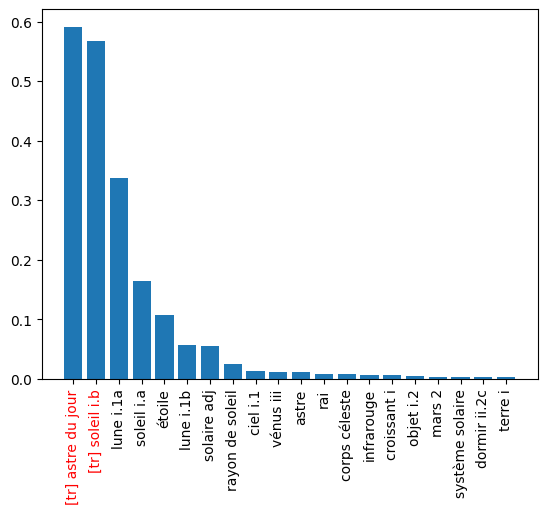

In [12]:
visualize_predictions(model, 'soleil i.a', 'syn', n = 20)

In [13]:
# To just get gold outputs:
train_objs, train_rels, valid_objs, valid_rels, test_objs, test_rels = get_gold(model, dfs, 2)
train_objs[:4]

[3, 65, 3699, 7171]

In [14]:
# Can do it with node labels as well
train_objs, train_rels, valid_objs, valid_rels, test_objs, test_rels = get_gold(model, dfs, 'pluie i')
train_objs[:4]

[5, 1388, 992, 3190]

In [15]:
# Can filter with relations as well
train_objs, train_rels, valid_objs, valid_rels, test_objs, test_rels = get_gold(model, dfs, 'pluie i', 'syn')
train_objs[:4]

[177, 8421, 17461, 17817]

In [16]:
# Relations can be numbers as well
train_objs, train_rels, valid_objs, valid_rels, test_objs, test_rels = get_gold(model, dfs, 'pluie i', 2)
train_objs[:4]

[5, 2252, 1416, 3108]

In [17]:
# Can ask to give text outputs instead
get_gold(model, dfs, 'soleil i.a', 0, return_str=True)


(['soleil i.b', 'astre du jour'], ['syn', 'syn'], [], [], [], [])